(ode:stiff-ode)=
## Numerical solution of ordinary differential equations: Stiff problems

And of course we want to import the required modules.

In [3]:
%matplotlib inline

import numpy as np
from numpy import pi
from numpy.linalg import solve, norm    
import matplotlib.pyplot as plt

# Use a funny plotting style
plt.xkcd()
newparams = {'font.family': 'Humor Sans',
             'figure.figsize': (6.0, 6.0), 'axes.grid': True,
             'lines.markersize': 8, 'lines.linewidth': 2,
             'font.size': 14}
plt.rcParams.update(newparams)

In [15]:
import matplotlib.font_manager
matplotlib.font_manager.findfont("Humor Sans")

'C:\\Users\\solni\\AppData\\Local\\Packages\\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\\LocalCache\\local-packages\\Python311\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSans.ttf'

(ssec:ex_euler_stiff)=
### Explicit Euler method and a stiff problem

We start by taking a second look at the IVP

$$
y'(t) = \lambda y(t), \quad y(t_0) = y_0.
$$ (stiff:ode:eq:exponential)

with the analytical solution

\begin{equation}
y(t) = y_0 e^{\lambda(t-t_0)}.
\end{equation}


Recall that for $\lambda > 0$ this equation can present a simple model
for the growth of some population, while a negative $\lambda < 0$
typically appears in decaying processes (read "negative growth").

So far we have only solved ([1](#stiff:ode:eq:exponential)) numerically
for $\lambda > 0$. Let's start with a little experiment.
First, we set $y_0 = 1$ and $t_0 = 0$.
Next, we chose different $\lambda$ to model processes with various
decay rates, let's say

$$
\lambda \in \{ -10, -50, -250\}.
$$

For each of those $\lambda$, we set a reference step length

$$
\tau_{\lambda} = \dfrac{2}{|\lambda|}
$$

(we will soon see why!) and compute a numerical solution using the explict Euler method
for three different time steps, namely for
$
\tau \in
\{
0.1 \tau_{\lambda},
\tau_{\lambda},
1.1 \tau_{\lambda}
\}
$
and plot the numerical solution together with the exact solution.

In [16]:
def explicit_euler(y0, t0, T, f, Nmax):
    ys = [y0]
    ts = [t0]
    dt = (T - t0)/Nmax
    while(ts[-1] < T):
        t, y = ts[-1], ys[-1]  
        ys.append(y + dt*f(t, y))
        ts.append(t + dt)
    return (np.array(ts), np.array(ys))

findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans'

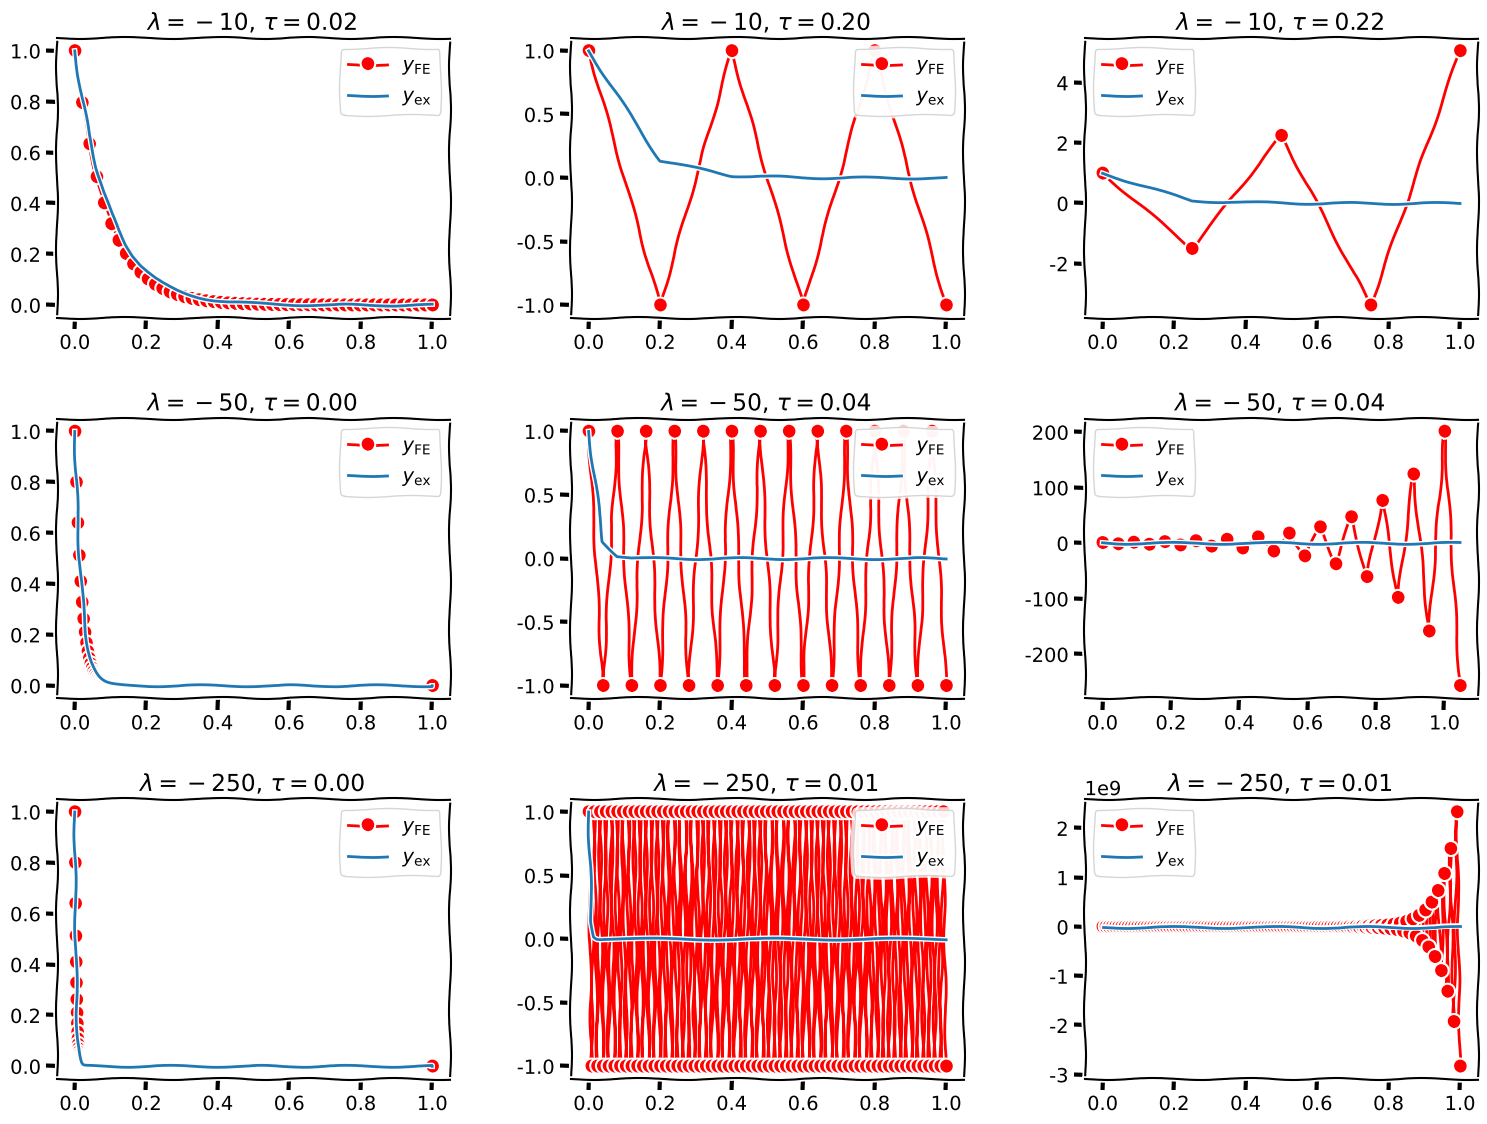

In [17]:
plt.rcParams['figure.figsize'] = (16.0, 12.0)
t0, T = 0, 1
y0 = 1
lams = [-10, -50, -250]

fig, axes = plt.subplots(3,3)
fig.tight_layout(pad=3.0)

for i in range(len(lams)):
    lam = lams[i]
    tau_l = 2/abs(lam)
    taus = [0.1*tau_l, tau_l, 1.1*tau_l]

    # rhs of IVP
    f = lambda t,y: lam*y

    # Exact solution to compare against
    y_ex = lambda t: y0*np.exp(lam*(t-t0))

    # Compute solution for different time step size
    for j in range(len(taus)):
        tau = taus[j]
        Nmax = int(1/tau)
        ts, ys = explicit_euler(y0, t0, T, f, Nmax)
        ys_ex = y_ex(ts)
        axes[i,j].set_title(f"$\\lambda = {lam}$, $\\tau = {tau:0.2f}$")
        axes[i,j].plot(ts, ys, "ro-")
        axes[i,j].plot(ts, ys_ex)
        axes[i,j].legend([r"$y_{\mathrm{FE}}$", "$y_{\\mathrm{ex}}$"])

:::{prf:observation}

Looking at the first column of the plot,
we observe a couple of things.
First, the numerical solutions computed with a time step $\tau = 0.1 \tau_{\lambda}$
closely resembles the exact solution.
Second, the exact solution approaches for larger $t$
a stationary solution (namely 0), which does not change significantly over time.
Third, as expected, the exact solution decays the faster the larger the absolute
value of $\lambda$ is. 
In particular for $\lambda = -250$, the
exact solution $y_{\mathrm{ex}}$
drops from 
$y_{\mathrm{ex}}(0) = 1$
to
$y_{\mathrm{ex}}(0.05) \approx 3.7\cdot 10^{-6}$
at $t = 0.05$, and
at $t=0.13$,
the exact solution is practically indistinguishable
from $0$ as
$y_{\mathrm{ex}}(0.13) \approx 7.7\cdot 10^{-16}$.

Looking at the second column, we observe that
a time-step size $\tau =  \tau_{\lambda}$,
the numerical solution oscillates between
$-1$ and $1$, and thus the numerical
solution does not resemble at all the
monotonic and rapid decrease of the exact solution.
The situation gets even worse for a time-step size
$\tau > \tau_{\lambda}$ (third column) where the the numerical solution growths
exponentially (in absolute values) instead of decaying exponentially
as the $y_{\mathrm{ex}}$ does.

:::

So what is happening here? Why is the explicit Euler method behaving so strangely?
Having a closer look at the computation of a single step in Euler's method
for this particular test problem, we see that

\begin{align*}
y_{i+1} &= y_i + \tau f(t_i, y_i)
= y_i + \tau \lambda y_i
= (1 + \tau \lambda) y_i 
= (1 + \tau \lambda)^2 y_{i-1}
= \ldots
= (1 + \tau \lambda)^{i+1} y_0
\end{align*}

Thus, for this particular IVP, the next step $y_{i+1}$ is simply computed by
by multiplying the current value $y_i$ with the the function $(1+\tau\lambda)$.

\begin{align*}
y_{i+1} = R(z)^{i+1} y_0, \quad z = \tau \lambda
\end{align*}

where $R(z) = (1+z)$ is called the **stability function** of the
explicit Euler method.

Now we can understand what is happening. Since $\lambda < 0$ and $\tau > 0$,
we see that as long as
$
\tau \lambda >  - 2 \Leftrightarrow  \tau < \dfrac{2}{|\lambda|}
$, we have
that $|1 + \tau \lambda| < 1$ and therefore,
$|y_i| = |1 + \tau \lambda|^{i+1} y_0$ is decreasing and
converging to $0$ 
For $\tau = \dfrac{2}{|\lambda|} = \tau_{\lambda}$,
we obtain

$$
y_{i+1} = (1 + \tau \lambda)^{i+1} y_0 = (-1)^{i+1} y_0
$$

so the numerical solution will be jump between $-1$ and
$1$, exactly as observed in the numerical experiment.
Finally, for
$\tau > \dfrac{2}{|\lambda|} = \tau_{\lambda}$,
$|1 + \tau \lambda| > 1$, and
$|y_{i+1}| = |1 + \tau \lambda|^{i+1} y_0$
is growing exponentially.

Note, that is line of thoughts hold independent of
the initial value $y_0$.
So even if we just want to solve our test problem ([1](#stiff:ode:eq:exponential))
*away* from the transition zone where $y_{\mathrm{ex}}$ drops
from $1$ to almost $0$, we need to apply a
time-step $\tau <  \tau_{\lambda}$ to avoid
that Euler's method produces a completely wrong
solution which exhibits exponential growth instead of
exponential decay.

:::{admonition} Summary


For the IVP problem {ref}`stiff:ode:eq:exponential`,
Euler's method has to obey a time step restriction
$\tau < \dfrac{2}{|\lambda|}$ to avoid numerical instabilities
in the form of exponential growth.

This time restriction becomes more severe the larger the absolute value
of $\lambda < 0$ is. On the other hand, the larger
the absolute value of $\lambda < 0$ is, the faster
the actual solution approaches the stationary solution $0$.
Thus it would be reseaonable to use large time-steps when
the solution is close to the stationary solution. Nevertheless,
because of the time-step restriction and stability issues,
we are forced to use very small time-steps, despite the fact that the
exact solution is not changing very much. This is a typical characteristic of
a **stiff problem**.
So the IVP problem {ref}`stiff:ode:eq:exponential` gets "stiffer"
the larger the absolute value of $\lambda < 0$ is,
resulting in a severe time step restriction
$\tau < \dfrac{2}{|\lambda|}$ to avoid numerical instabilities.


:::

**Outlook.**
Next, we will consider other one-step methods and investigate
how they behave when applied to the test problem {ref}`stiff:ode:eq:exponential`.
All these one step methods will have a common, that the advancement
from $y_{k}$ to $y_{k+1}$ can be written as

$$
y_{k+1} = R(z) y_{k} \quad \text{with } z = \tau \lambda
$$

for some **stability function** $R(z)$.


With our previous analysis in mind
we will introduce the following

:::{prf:definition} Stability domain

Let $R(z)$ be the stability function for some one-step function.
Then the domain

$$
\mathcal{S} = \{ z \in \mathbb{R}: |R(z)| \leqslant 1 \}
$$ (stiff:ode:stability_domain)


is called the **domain of stability**.

:::{prf:remark}
Usually, one consider the entire complex plane in the definition
of the domain of stability, that is, 
$\mathcal{S} = \{ z \in \mathbb{C}: |R(z)| \leqslant 1 \}$
but in this course we can restrict ourselves to only
insert real arguments in the stability function.
:::

Let's plot the domain of stability for the explicit Euler method.

In [7]:
def plot_stability_domain(r, xlim=(-3, 3), ylim=(-3, 3), resolution=500):
    """
    Plots the stability domain of a given rational function r(z) where |r(z)| <= 1.
    
    Parameters:
    - r: A function representing the rational function r(z).
    - xlim: Tuple representing the x-axis limits for the plot.
    - ylim: Tuple representing the y-axis limits for the plot.
    - resolution: The number of points along each axis for the grid.
    """
    # Create a grid of complex numbers
    x = np.linspace(xlim[0], xlim[1], resolution)
    y = np.linspace(ylim[0], ylim[1], resolution)
    X, Y = np.meshgrid(x, y)
    Z = X + 1j * Y
    
    # Compute |r(z)| on the grid
    R = np.abs(r(Z))
    
    # Plot the stability domain
    plt.figure(figsize=(8, 8))
    plt.contourf(X, Y, R, levels=[0, 1], colors=['blue'], alpha=0.5)
    plt.contour(X, Y, R, levels=[1], colors=['black'])
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel('Re(z)')
    plt.ylabel('Im(z)')
    plt.title('Stability Domain')
    plt.grid(True)
    plt.show()


findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans'

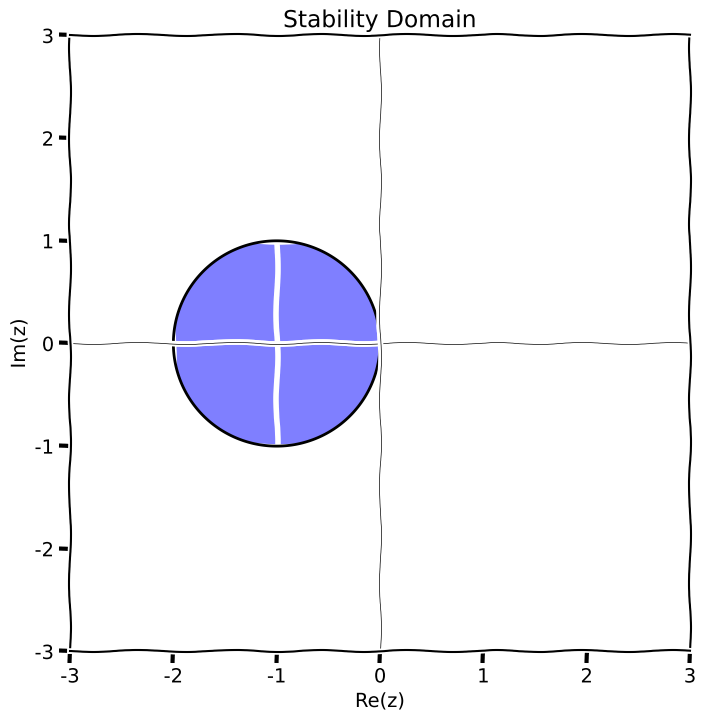

In [8]:
def r_fe(z):
    return 1 + z

plot_stability_domain(r_fe)

:::{important} Time-step restrictions for explicit RKM

Unfortunately, all **explicit Runge-Kutta methods** when
applied to the simple test problem {eq}`stiff:ode:eq:exponential`
will suffer from similar problems as the explicit Euler method,
for the following reason:

It can be shown that for any **explicit** RKM, its corresponding stability function $r(z)$
must be a polynomial in $z$. Since complex polynomials satisfy $|r(z)| \to \infty$ for $|z| \to \infty$, 
its **domain of stability** as defined above must be bounded. 
Consequently,
there will a constant $C$ such that any time step
$\tau > \dfrac{C}{|\lambda|}$ will lead to numerical instabilities.

:::

### The implicit Euler method
Previously, we considered Euler's method,
for the first-order IVP

$$
y'(t) = f(t,y(t)), \qquad y(t_0)=y_0
$$

where the new approximation $y_{k+1}$ at $t_{k+1}$
is defined by

$$
y_{k+1} := y_{k} + \tau f(t_{k}, y_{k})
$$

We saw that this could be interpreted as replacing
the differential quotient $y'$ 
by a **forward difference quotient**

$$
f(t_k,y_k) = y'(t_k) \approx
 \dfrac{y(t_{k+1}) - y(t_k)}{\tau}
$$

Here the term "forward" refers to the fact that we use a forward value $y(t_{k+1})$
at $t_{k+1}$ to approximate the differential quotient at $t_k$.

Now we consider a variant of Euler's method, known as the
**implicit** or **backward** Euler method.
This time, we simply replace
the differential quotient $y'$ 
by a **backward difference quotient**

$$
f(t_k,y_k) = y'(t_k) \approx
 \dfrac{y(t_{k}) - y(t_{k-1})}{\tau}
$$

resulting in the following

:::{prf:algorithm} Implicit/backward Euler method

Given a function $f(t,y)$ and an initial value $(t_0,y_0)$.
* Set $t = t_0$, choose $\tau$.

* $\texttt{while } t < T$:

  * $\displaystyle y_{k+1} := y_{k} + \tau f(t_{k+1}, y_{k+1})$ 

  * $t_{k+1}:=t_k+\tau$

  * $t := t_{k+1}$

:::


Note that in contrast to the explicit/forward Euler, the new value
of $y_{k+1}$ is only *implicitly* defined as it appears both on the
left-hand side and right-hand side.
Generally, if $f$ is nonlinear in its $y$ argument, this amounts
to solve a non-linear equation, e.g., by using fix-point iterations
or Newton's method. But if $f$ is linear in $y$, that we only
need to solve a *linear system*.

Let's see what we get if we apply the backward Euler method
to our model problem.



<!-- --- begin exercise --- -->

:::{exercise} Implicit/backward Euler method
:label: ode:exe:impl_eul

**a)**
Show that the backward difference operator (and therefore the
backward Euler method) has consistency order $1$, that is,

$$
y(t) + \tau f(t+\tau, y(t+\tau)) - y(t+\tau) = \mathcal{O}(\tau^2)
$$

**b)**
Implement the implicit/backward Euler method

```Python
        def implicit_euler(y0, t0, T, lam, Nmax):
          ...
```

for the IVP ([1](#stiff:ode:eq:exponential)).
Note that we now take $\lambda$ as a parameter, and
not a general function $f$ as we want to keep as simple
as possible Otherwise we need to implement a nonlinear
solver if we allow for arbitrary right-hand sides $f$.
You use the code for `explicit_euler` as a start point.

**c)**
Write down the Butcher table for the implicit Euler method.

**d)** Rerun the numerical experiment from the previous section with the implicit Euler method. Do you observe any instabilities?

**e)**
Find the stability function $R(z)$
for the implicit Euler satisfying

\begin{equation}
y_{k+1} = R(\tau \lambda) y_{k}
\end{equation}

and use it to explain the much better behavior of the implicit Euler when solving
the initial value problem {eq}`stiff:ode:eq:exponential`.


:::

:::{solution-start} ode:exe:impl_eul
:::

**a)** As before, we simply do a Taylor expansion of $y$, but
this time around $t+\tau$.
Then

$$
y(t) = y(t+ \tau) - \tau y'(t+ \tau) + \mathcal{O}(\tau^2)
= y(t+ \tau) - \tau f(t+ \tau, y(t+ \tau)) + \mathcal{O}(\tau^2)
$$

which after rearranging terms is
exactly ([4](#stiff:ode:eq:consist_be)).

**b)**

In [9]:
# Warning, implicit Euler is only implement for the test equation
# not a general f!
def implicit_euler(y0, t0, T, lam, Nmax):
    ys = [y0]
    ts = [t0]
    dt = (T - t0)/Nmax
    while(ts[-1] < T):
        t, y = ts[-1], ys[-1]  
        ys.append(y/(1-dt*lam))
        ts.append(t + dt)
    return (np.array(ts), np.array(ys))

**c)**

$$
\begin{array}{c|c}
1 & 1
\\ 
\hline
& 1
\end{array}
$$

**d)**

findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Humor Sans'

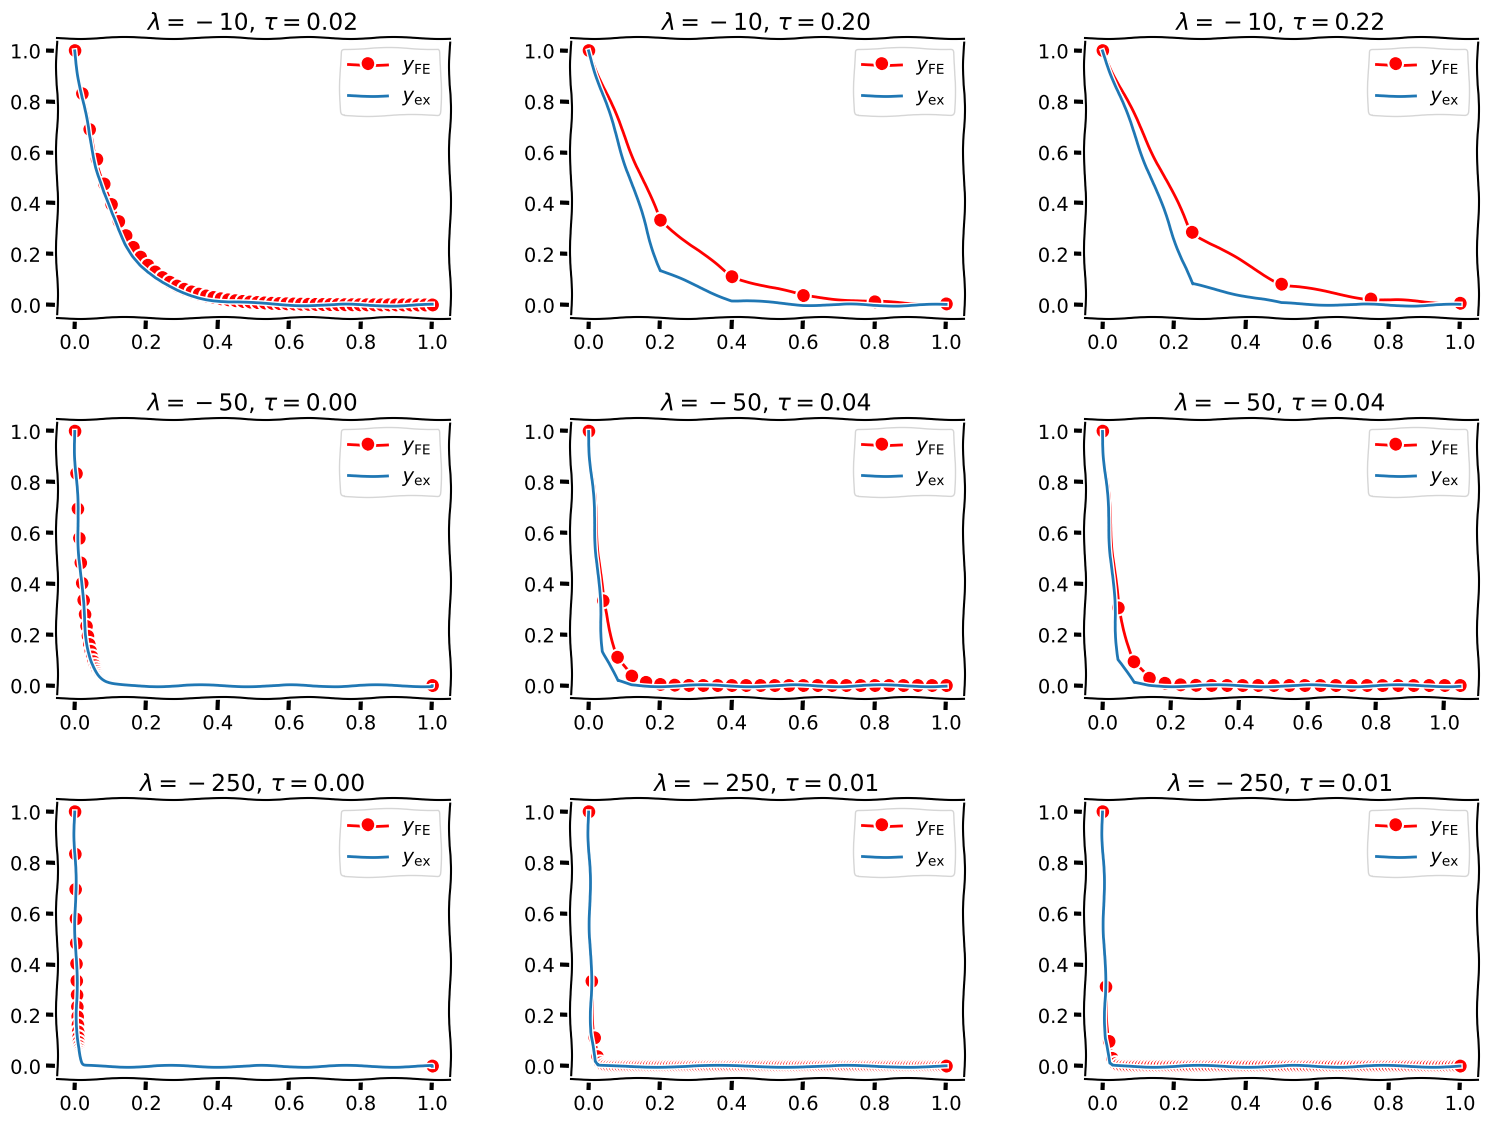

In [10]:
plt.rcParams['figure.figsize'] = (16.0, 12.0)
t0, T = 0, 1
y0 = 1
lams = [-10, -50, -250]

fig, axes = plt.subplots(3,3)
fig.tight_layout(pad=3.0)

for i in range(len(lams)):
    lam = lams[i]
    tau_l = 2/abs(lam)
    taus = [0.1*tau_l, tau_l, 1.1*tau_l]

    # rhs of IVP
    f = lambda t,y: lam*y

    # Exact solution to compare against
    y_ex = lambda t: y0*np.exp(lam*(t-t0))

    # Compute solution for different time step size
    for j in range(len(taus)):
        tau = taus[j]
        Nmax = int(1/tau)
        ts, ys = implicit_euler(y0, t0, T, lam, Nmax)
        ys_ex = y_ex(ts)
        axes[i,j].set_title(f"$\\lambda = {lam}$, $\\tau = {tau:0.2f}$")
        axes[i,j].plot(ts, ys, "ro-")
        axes[i,j].plot(ts, ys_ex)
        axes[i,j].legend([r"$y_{\mathrm{FE}}$", "$y_{\\mathrm{ex}}$"])

**e)**
For $y' = \lambda y =: f(t,y)$, the implicit Euler gives


\begin{equation}
y_{k+1} = y_{k} + \tau \lambda y_{k+1}
\end{equation}



$$
\Leftrightarrow
\;  y_{k+1} = \dfrac{1}{1 - \tau \lambda} y_k
= \left(\dfrac{1}{1 - \tau \lambda}\right)^{k+1} y_0.
$$


Thus $R(z) = \tfrac{1}{1-z}$. The domain of stability
is $\mathcal{S} = (-\infty, 0] \cup [2, \infty)$, in particular,
no matter how we chose $\tau$, $|R(\lambda z)| < 1$
for $\lambda < 0$. So the implicit Euler method is stable
for the test problem ([1](#stiff:ode:eq:exponential)),
independent of the choice of the time step.

We can even plot it:

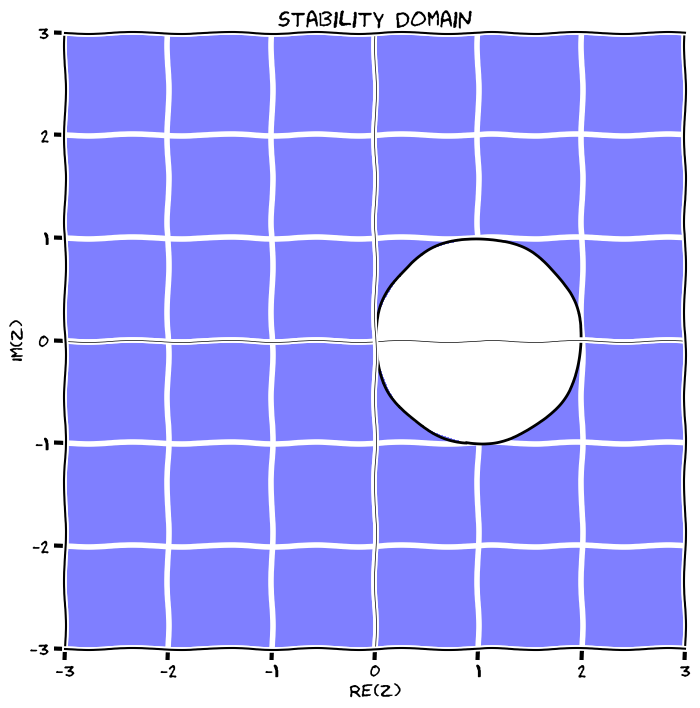

In [20]:
def r_fe(z):
    return 1/(1 - z)

plot_stability_domain(r_fe)

:::{solution-end}
:::

### The Crank-Nicolson
Both the explicit/forward and the implicit/backward Euler method
have consistency order $1$. Next we derive
2nd order method.
We start exactly as in the derivation of Heun's method
presented in the `IntroductionNuMeODE.ipynb` notebook.

Again, we start from the *exact integral representation*,
and apply the trapezoidal rule

\begin{align*}
y(t_{k+1}) - y(t_k)
&=
\int_{t_k}^{t_{k+1}} f(t,y(t)) {\,\mathrm{d}t}
\approx
\dfrac{\tau_k}{2}
\left(
f(t_{k+1}, y(t_{k+1})
+
f(t_{k}, y(t_{k})
\right)
\end{align*}

This suggest to consider the *implicit* scheme

$$
\begin{align*}
y_{k+1} 
&=
y_k +
\dfrac{\tau_k}{2}
\left(
f(t_{k+1}, y_{k+1})
+
f(t_{k}, y_{k})
\right)
\end{align*}
$$

which is known as the **Crank-Nicolson method**.
 

:::{exercise-start} Investigating the Crank-Nicolson method
:label: ode:ex:cn-method
:::

**a)**
Determine the Butcher table for the Crank-Nicolson method.


<!-- --- begin solution of exercise --- -->
**Solution.**
We can rewrite Crank-Nicolson using two stage-derivatives $k_1$ and $k_2$ as follows.

\begin{align*}
k_1 &= f(t_{k}, y_{k})
=
f(t_{k} + 0 \cdot \tau,
y_{k}
+ \tau(
0 \cdot k_1
+ 0 \cdot k_2
))
 \\ 
k_2 &=
f(t_{k+1}, y_{k+1})
= 
f(t_{k} + 1 \cdot \tau,
y_{k}
+ \tau(\tfrac{1}{2} k_1
+ \tfrac{1}{2} k_2))
\\ 
y_{k+1} &= y_{k} + \tau(\tfrac{1}{2} k_1 + \tfrac{1}{2} k_2)
\end{align*}

and thus the Butcher table is given by

$$
\begin{array}{c|c c}
0 & 0 & 0
\\ 
1 & \tfrac{1}{2}  & \tfrac{1}{2}
\\ 
\hline
& \tfrac{1}{2}  & \tfrac{1}{2}
\end{array}.
$$

<!-- --- end solution of exercise --- -->

**b)**
Use the order conditions discussed in the `RungeKuttaNuMeODE.ipynb`
to show that Crank-Nicolson is of consistency/convergence order 2.

**c)**
Determine the stability function $R(z)$ associated with the
Crank-Nicolson method and discuss the implications on the stability of
the method for the test problem ([1](#stiff:ode:eq:exponential)).


<!-- --- begin solution of exercise --- -->
**Solution.**
With $f(t,y) = \lambda y$,

\begin{align*}
y_{k+1} 
&=
y_k +
\dfrac{\tau}{2}
\lambda y_{k+1}
+
\dfrac{\tau}{2}
\lambda y_{k}
\end{align*}

and thus

\begin{align*}
y_{k+1} 
&=
\dfrac{1+\tfrac{\tau \lambda}{2}}
{1-\tfrac{\tau \lambda}{2}}
y_k
\end{align*}

and therefore

$$
R(z) =
\dfrac{1+\tfrac{z}{2}}
{1-\tfrac{z}{2}}.
$$

As result, the stability domain $(-\infty, 0] \subset \mathcal{S}$,
in particular, Crank-Nicolson is stable for our test problem,
independent of the choice of the time-step.

**d)**
Implement the Crank-Nicolson method to solve the
test problem (stiff:ode:eq:exponential) numerically.

**Hint.**
You can start from `implicit_euler` function implemented earlier, you only need to change
a single line.

**e)**
Check the convergence rate for your implementation by solving 
(stiff:ode:eq:exponential)
with $\lambda = 2$, $t_0 = 1, T = 2$
and $y_0 = 1$ for various time step sizes and compute the
corresponding experimental order of convergence (EOC)

**f)**
Finally, rerun the stability experiment from
the section {ref}`ssec:ex_euler_stiff`
with Crank-Nicolson.

:::{exercise-end} 
:::

# The $\theta$-method
All the numerical methods we discussed here can be combined
into one single method, known as the **$\theta$-method**.

## Definition 2: The $\theta$-method

For $\theta \in [0,1]$, the one-step $\theta$ method is defined by


$$
y_{i+1} = y_i + \theta f(t_{i+1}, y_{i+1}) + (1-\theta)  f(t_{i}, y_{i}),
$$ (stiff:ode:eq:theta_method)

so for a given $\theta$, a weighted sum/convex combination 
of $f(t_{i+1}, y_{i+1})$ and $f(t_{i}, y_{i})$ is taken.


**Observation.**

Note that for
* $\theta = 0$, we obtain the explicit/forward Euler method,

* $\theta = 1$, we obtain the implicit/backward Euler method,

* $\theta = \tfrac{1}{2}$, we obtain the Crank-Nicolson method.